# P2: Experimenting with hyperparameters for Quantum Machine Learning.
We look at a simple QNN algorithm and experiment with its hyperparameters.
The hyperparameters have been taken from Section 3.1 of [this](https://www.researchgate.net/publication/361456049_Hyperparameter_Importance_of_Quantum_Neural_Networks_Across_Small_Datasets) paper.
Hyperparameters used are parameters similar to #4, #10 in the paper listed above. In particular, we look at different ways of encoding to and decoding the quanvolution circuit. We plot the results.

Encoding: We experiment with different rotation matrices($R_x, R_y, R_z$) to encode image data in the circuit.
Decoding: We experiment with different observables($X, Y, Z, H$) whose expectation is used to decode the circuit.

This implementation uses: The MNIST dataset, 250 Training examples, 50 Test examples, Simple one-layer classical NN, 4 quanvolution channels.
This network is based on [this](https://arxiv.org/abs/1904.04767) paper and [this](https://pennylane.ai/qml/demos/tutorial_quanvolution.html) section of the PennyLane QML Demos.

In [147]:
import pennylane as qml
from pennylane.devices.default_qubit import DefaultQubit
import tensorflow as tf
from tensorflow import keras
import pennylane.numpy as np
from matplotlib import pyplot as plt
from time import time

In [148]:
qubits = 4
dev = DefaultQubit(wires=qubits) # dev is an instance of a DefaultQubit object.

# Some parameters of the model.
n_epochs = 10
n_train = 250
n_test = 50
n_rlayers = 1 # The number of layers(a bunch of gates) in the random circuit.
np.random.seed(0)
rparams = np.random.uniform(low=0, high=2*np.pi, size=(n_rlayers, 4)) # four random (but fixed throughout the code) params for the q.ckt of each rlayer.
tf.random.set_seed(0)

In [149]:
# load mnist dataset. Same as Week4/mnist.ipynb, only change is we take only a subset of the data here, not full thing.

# use the MNIST black&white handwriting dataset already present in keras
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() # capital letters to indicate a vectorized version of the whole training data(the X in logistic regression)

# shrink data to the size we chose.
X_train = X_train[:n_train]; y_train = y_train[:n_train]
X_test = X_test[:n_test]; y_test = y_test[:n_test]

# normalize the pixel values to be in [0, 1]
X_train = X_train/255; X_test = X_test/255 

# gets 7 to [0 0 0 0 0 0 1 0 0 0]
y_train = keras.utils.to_categorical(y_train, num_classes=10) # default num_classes is max number in arrayy - min number in array +1(both incl)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# recast the n_train x 28 x 28 numpy array X_train into a n_train x 28 x 28 x 1 numpy array. Why? Convolution expects a 4d array(one dimension for color).
X_train = X_train.reshape(*(X_train.shape), 1)
X_test = X_test.reshape(*(X_test.shape), 1)
print("Loaded.")

Loaded.


### The Quanvolution Circuit.
We now build the circuit that performs the quanvolution. This is not, strictly speaking, a convolution operation, rather a quantum circuit encoded with the image values is passed through a random(but constant throughout) quantum circuit and then an output(the result of the quanvolution) is returned(the output can be an expectation value or a measurement outcome - something to do with measurement of the final state).

In this example, the encoding is done as $$f: x \in [0, 1] \rightarrow \cos(\frac{\pi x}{2})|0\rangle + \sin(\frac{\pi x}{2})|0\rangle = R_y(\pi x)|0\rangle \text{  - a very neat representation indeed!}$$

The decoding is fairly simple - Each qubit returns the expectation value of the observable Pauli-$Z$.
Note that each qubit acts as one filter and so we have four filters as output, hence the shape of the output tensor is n_train x 14 x 14 x 4(stride = 2 so 14 x 14, but four channels(feature maps)).

The following code for the circuit function has these as default, but we generalize the code to work for other encoding-decoding patterns as well.

In [150]:
@qml.qnode(dev)
def circuit(params, encode='ry', decode='pauliZ'):
    # encode. Note that the initial state is |0\rangle.
    if encode == 'rx':
        for i in range(4): qml.RX(np.pi * params[i], i)
    elif encode == 'ry':
        for i in range(4): qml.RY(np.pi * params[i], i)
    elif encode == 'rz':
        for i in range(4): qml.RZ(np.pi * params[i], i)

    # pass this state through the rlayer(s).
    from pennylane.templates import RandomLayers
    RandomLayers(weights=rparams, wires=range(4))

    # decode.
    if decode == 'pauliX':
        return [qml.expval(qml.PauliX(i)) for i in range(4)]
    if decode == 'pauliY':
        return [qml.expval(qml.PauliY(i)) for i in range(4)]
    if decode == 'pauliZ':
        return [qml.expval(qml.PauliZ(i)) for i in range(4)]
    if decode == 'energy':
        return [qml.expval(qml.Hadamard(i)) for i in range(4)]

In [151]:
def quanvolution(image, encode='ry', decode='pauliZ'):
    ans = np.zeros(shape=(14, 14, 4))
    for i in range(14):
        for j in range(14):
            res = circuit([
                image[2*i][2*j][0],     image[2*i + 1][2*j][0], 
                image[2*i][2*j + 1][0], image[2*i + 1][2*j + 1][0],
            ], encode=encode, decode=decode)
            # assign the channels
            for k in range(4): ans[i][j][k] = res[k]
    return ans

def quanvolute(images, encode='ry', decode='pauliZ'):
    return np.array([quanvolution(image, encode, decode) for image in images])

In [152]:
def getModel():
    """return a model ready for training. Similar to(and simpler than) mnist.ipynb"""
    ans = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units=10, activation='softmax')
    ])
    ans.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return ans

In [153]:
# A classical model
cmodel = getModel()
print('Training...')
chistory = cmodel.fit(X_train, y_train, epochs=n_epochs, verbose=0)
print('Trained.\nTesting...')
cmodel.evaluate(X_test, y_test, verbose=1)

Training...
Trained.
Testing...
2/2 [==============================] - 0s 919us/step - loss: 1.1028 - accuracy: 0.7200


[1.1028097867965698, 0.7200000286102295]

In [154]:
# A hybrid model - a quanvolution followed by a classical model. Does act like a convolution channel and hence gives more accuracy, but takes a huge amount of time.
def qnn(encode='ry', decode='pauliZ'):
    qmodel = getModel()
    print('Training...')
    print('Quanvoluting training and test datasets...')
    start = time()
    qX_train = quanvolute(X_train, encode=encode, decode=decode) # Essentially, the quanvolute step is the first layer of processing in the net.
    qX_test = quanvolute(X_test, encode=encode, decode=decode)
    print(f'Quanvolution completed on {n_train} + {n_test} samples. Time taken = {(time() - start):.2f}s')

    print('Classical Layers...')
    qhistory = qmodel.fit(qX_train, y_train, epochs=n_epochs, verbose=0) 
    print('Trained.\nTesting...')
    qmodel.evaluate(qX_test, y_test, verbose=1)
    print()
    return qhistory

# Vary the encoding, with decoding='pauliZ'(the default)
print('Qmodel with encoding RX.')
qhis_x = qnn('rx')
print('Qmodel with encoding RY.')
qhis_y = qnn('ry')
print('Qmodel with encoding RZ.')
qhis_z = qnn('rz')

Qmodel with encoding RX.
Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 99.76s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 1.0333 - accuracy: 0.7000

Qmodel with encoding RY.
Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 98.59s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 1.0104 - accuracy: 0.6800

Qmodel with encoding RZ.
Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 94.98s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 2.3189 - accuracy: 0.1200



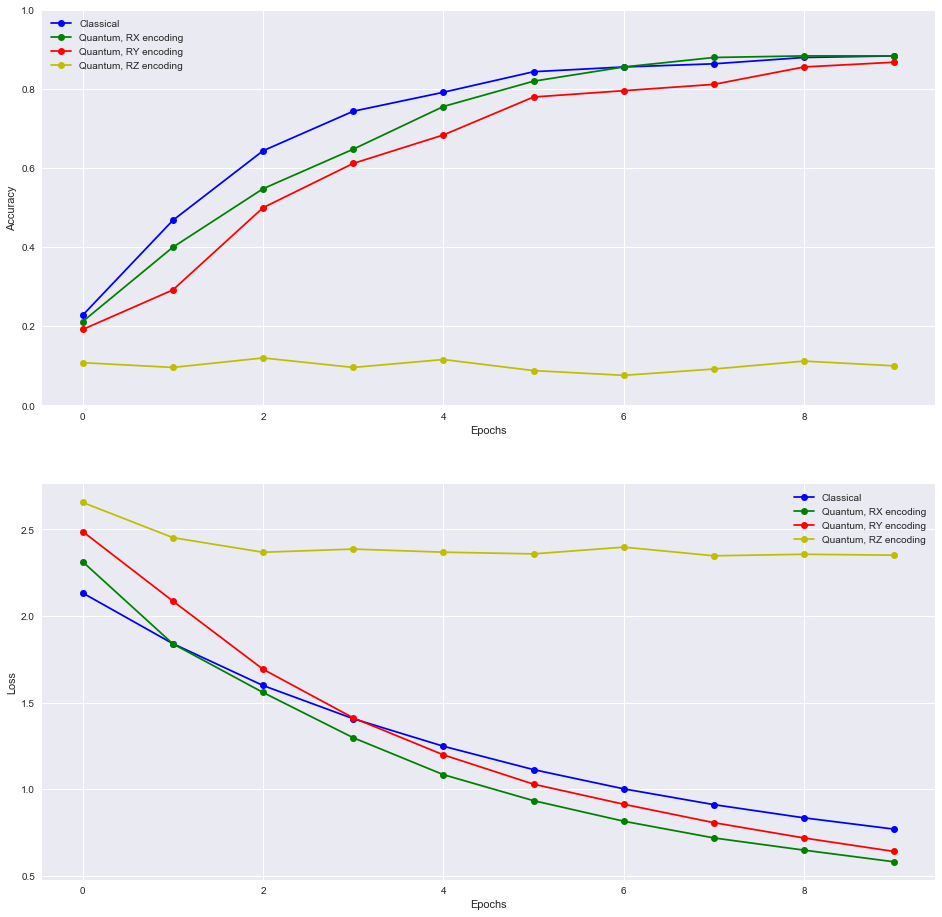

In [155]:
# plot the data.
plt.style.use(style='seaborn')
figure, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# on first subplot, plot the accuracy of the models.
axes1.plot(chistory.history['accuracy'], 'b-o', label='Classical') # plot using (b)lue 'o's. similarly 'r+' plots red plusses. The - is to connect all resulting points in the plot.
axes1.plot(qhis_x.history['accuracy'], 'g-o', label='Quantum, RX encoding')
axes1.plot(qhis_y.history['accuracy'], 'r-o', label='Quantum, RY encoding')
axes1.plot(qhis_z.history['accuracy'], 'y-o', label='Quantum, RZ encoding')
axes1.set_ylabel('Accuracy')
axes1.set_xlabel('Epochs')
axes1.set_ylim([0, 1])
axes1.legend()

# id to above, ony change: Accuracy -> Loss. Plotted on second subplot.
axes2.plot(chistory.history['loss'], 'b-o', label='Classical') # plot using (b)lue 'o's. similarly 'r+' plots red plusses. The - is to connect all resulting points in the plot.
axes2.plot(qhis_x.history['loss'], 'g-o', label='Quantum, RX encoding')
axes2.plot(qhis_y.history['loss'], 'r-o', label='Quantum, RY encoding')
axes2.plot(qhis_z.history['loss'], 'y-o', label='Quantum, RZ encoding')
axes2.set_ylabel('Loss')
axes2.set_xlabel('Epochs')
axes2.legend()

We make an important observation here. Note that the encoding = 'rz' isn't useful. Why? Since it is actually not encoding anything at all! The state $|0\rangle$ under $R_z(\theta)$ is mapped to itself(upto a phase) and so the circuit didn't really encode any data, all qubits are still in $|0\rangle$. So the quanvolution gives the same output whatever the input, or in other words the answer we get is independent of the input or the model classifies all images as the same thing and so gets it right (in a uniform distribution) 10% of the time. It's not learning from the data, it just simply makes the same guess everytime.

In [156]:
# changing the decoding, encoding is rx, ry(rz is anyway not helping).
encodings = ['rx', 'ry']
decodings = ['pauliX', 'pauliY', 'pauliZ', 'energy']
qnns = [[] for i in range(len(encodings))]
for i, encoding in enumerate(encodings):
    for decoding in decodings:
        qnns[i].append(qnn(encode=encoding, decode=decoding))

Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 107.41s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 1.9540 - accuracy: 0.4200

Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 121.01s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 911us/step - loss: 1.9535 - accuracy: 0.5200

Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 99.09s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 0.8803 - accuracy: 0.7200

Training...
Quanvoluting training and test datasets...
Quanvolution completed on 250 + 50 samples. Time taken = 113.93s
Classical Layers...
Trained.
Testing...
2/2 [==============================] - 0s 1ms/step - loss: 1.0351 - accuracy: 0.7600

Training...
Qua

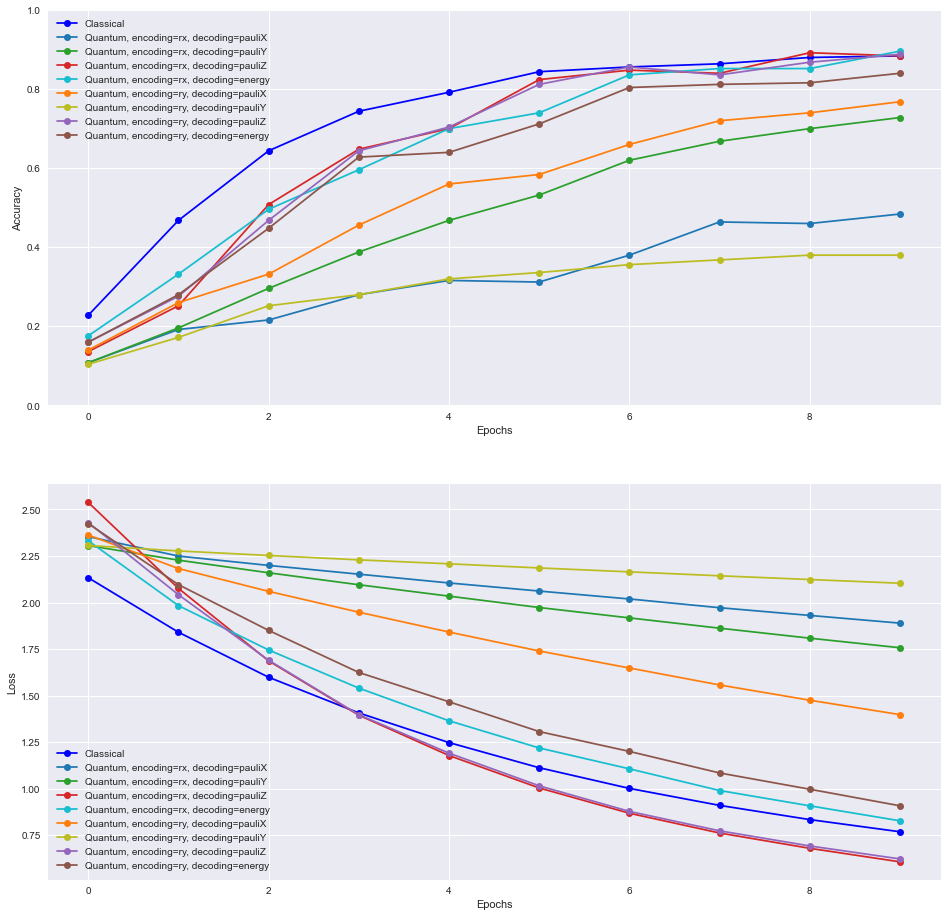

In [161]:
# plot the data.
plt.style.use(style='seaborn')
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'tab:olive', 'tab:purple', 'tab:brown']
figure, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# on first subplot, plot the accuracy of the models.
axes1.plot(chistory.history['accuracy'], 'b-o', label='Classical') 
for i, qnns_diff_decoding in enumerate(qnns):
    for j, qnn in enumerate(qnns_diff_decoding):
        axes1.plot(
            qnn.history['accuracy'], 
            '-o', color=colors[i*len(decodings) + j], 
            label=f'Quantum, encoding={encodings[i]}, decoding={decodings[j]}'
        )
axes1.set_ylabel('Accuracy')
axes1.set_xlabel('Epochs')
axes1.set_ylim([0, 1])
axes1.legend()

# id to above, ony change: Accuracy -> Loss. Plotted on second subplot.
axes2.plot(chistory.history['loss'], 'b-o', label='Classical') 
for i, qnns_diff_decoding in enumerate(qnns):
    for j, qnn in enumerate(qnns_diff_decoding):
        axes2.plot(
            qnn.history['loss'], 
            '-o', color=colors[i*len(decodings) + j], 
            label=f'Quantum, encoding={encodings[i]}, decoding={decodings[j]}'
        )
axes2.set_ylabel('Loss')
axes2.set_xlabel('Epochs')
axes2.legend()

From the graphs above, we observe:
- Circuits using the same rotation for both encoding and decoding ('rx', 'pauliX') and ('ry', 'pauliY') perform poorly.
- The circuits ('rx', 'pauliY') and ('ry', 'pauliX') seem to reduce the loss appromixately linearly, but not with a large slope. Moreover the two circuits are also very close in performance.
- The two circuits with decoding='energy' perform well, with accuracies similar to a classical model. However, their loss is higher than that of the classical model.
- Finally, the two circuits using decoding='pauliZ' perform the best, and like the decoding='energy' circuits, also have accuracies matching the classical model. However, their loss is even lower than the classical model and is the lowest of all.

So we conclude: Use an encoding='rx'/'ry' and a decoding of 'pauliZ'/'energy' for best results.